### Imports

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load the data

In [2]:
# Function to load and preprocess images
def load_images(data_dir, categories, img_size=224):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (img_size, img_size))
                images.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                continue
    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels

data_dir = "flower_images"
categories = ["Lilly", "Lotus", "Orchid", "Sunflower", "Tulip"]

images, labels = load_images(data_dir, categories)

In [3]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Load and build model

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.3257 - loss: 2.5858 - val_accuracy: 0.7253 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6279 - loss: 0.9605 - val_accuracy: 0.7613 - val_loss: 0.7585 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6991 - loss: 0.7603 - val_accuracy: 0.8240 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.7283 - loss: 0.7082 - val_accuracy: 0.8507 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7767 - loss: 0.5806 - val_accuracy: 0.8373 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7910 - loss: 0.5466 - val_accuracy: 0.8307 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7847 - loss: 0.

24/24 - 39s - 2s/step - accuracy: 0.9067 - loss: 0.3404
Test accuracy: 0.9066666960716248


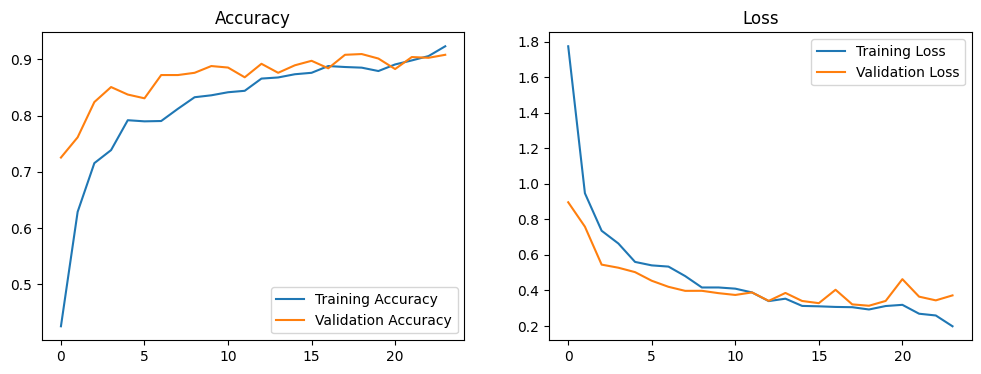

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [8]:
model.save('model/flower_classification.h5')